# Mini Project 4

**2025 Introduction to Quantitative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [2]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%run functions_black_scholes.py #black Scholes functions

In [61]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simulated stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    #paths
    paths = S0*np.exp(log_returns)
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths
    
    

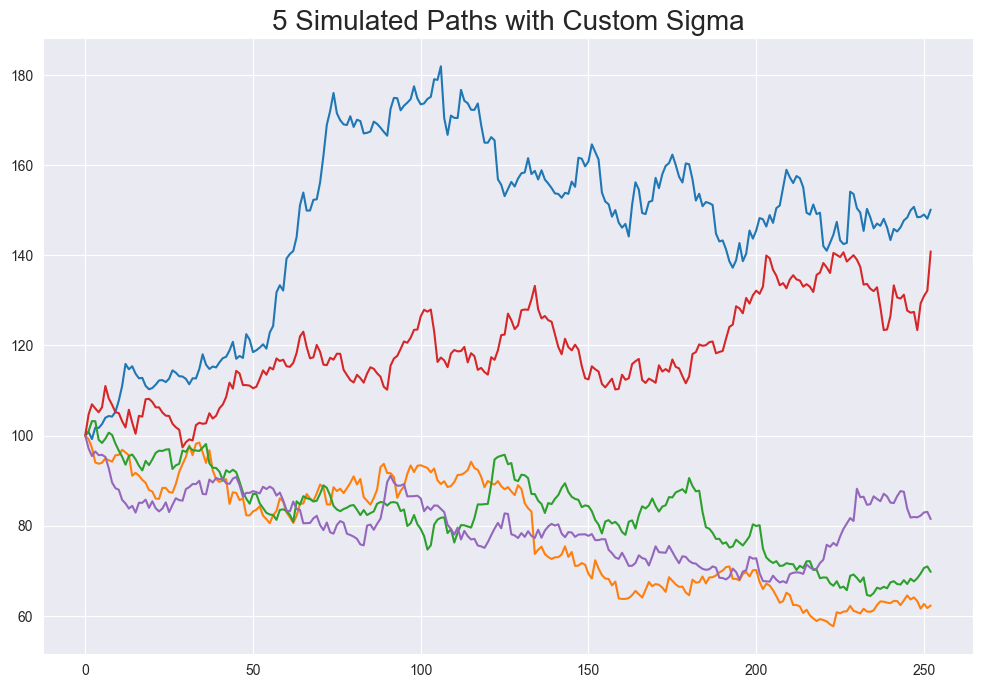

In [62]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0 #0.275
n_paths = 5
n_steps = 252

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)

plt.figure(figsize = (12,8))
for path in simulated_paths:
    plt.plot(path)  
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)
plt.show()

In [8]:
''' 
We will explore here a simulated stock path over one year based on geometric brownian motion with cut-off sinusoidal sigma.
The sinusoid is taken to have four peaks of volatility, corresponding to quarterly earnings reports.
Times away from earnings will have a constant baseline volatility.
Here sigma = max(A*sin(4*2*pi*t / 252)+base_sig, base_sig)

We will then test the effectiveness of selling options and delta hedging within this type of environment.

'''

#define our cut-sinusoid with 4 quarterly spikes: max(A*sin(4*2*pi*t/252) + base_sig, base_sig)
def cut_sin(A, base_sig, n_steps):
  sigma = [max(A*np.sin(4*2*np.pi*i / 252)+base_sig, base_sig) for i in range(n_steps)]
  return sigma

#return a tile of the cut-sinusoid
def cut_sin_tile(A, base_sig, n_steps, n_paths):
   return np.tile(cut_sin(A, base_sig, n_steps), (n_paths,1))

def stock_path_cut_sin_sigma(S0, t, r, mu, base_sig, A, n_paths, n_steps = 252):
    ''' 
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    base_sig (float): the lower bound on sigma, must be a positive number
    A (float): the amplitude of the sinusoidal fluctuation
    
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:    
    Simulated stock paths
    '''
    
		#assert base volatility is positive
    assert(base_sig > 0)
    
    #Noise in volatility, given by unit normal
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma: a cut off sinosoid
		#sigma = max(A*sin(4*2*pi*t / 252)+base_sig, base_sig)
    sigma = cut_sin_tile(A, base_sig, n_steps, n_paths)
  
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
        
    #paths
    paths = S0*np.exp(log_returns)
        
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths

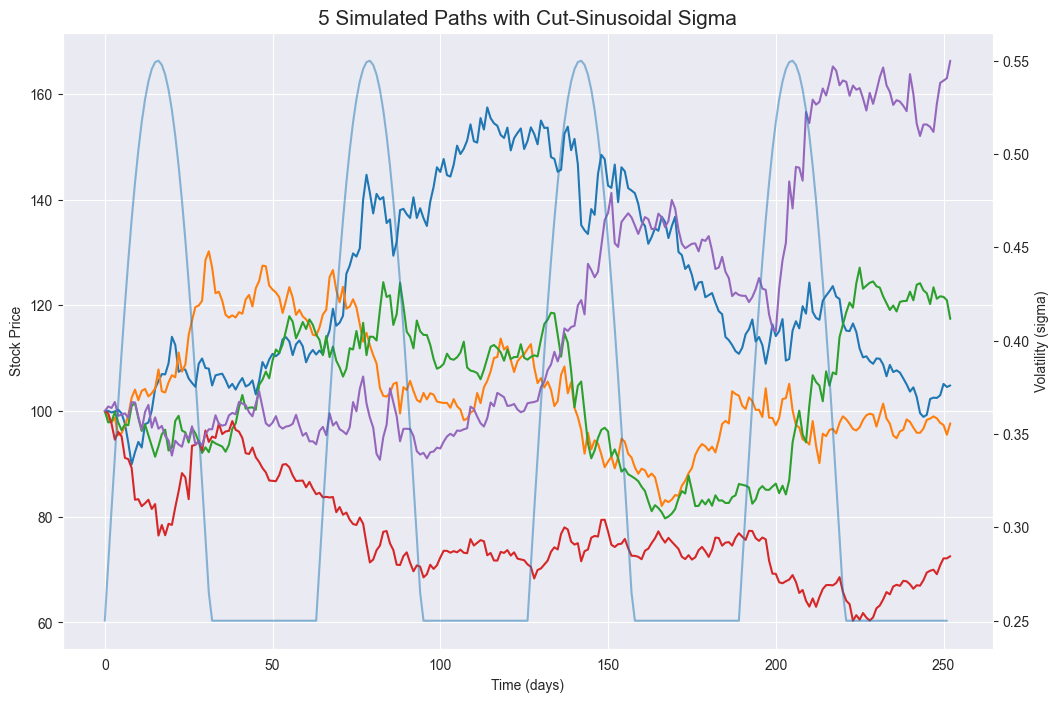

In [4]:

S0 = 100
t = 1
r = 0
mu = 0 #0.275
n_paths = 5
n_steps = 252
A = 0.3
base_sig = 0.25

#custom cut-sinusoid sigma
sigma = [ max(A*np.sin(4*2*np.pi*i / 252)+base_sig, base_sig) for i in range(n_steps)]

#simulate the stock paths
simulated_paths = stock_path_cut_sin_sigma(S0, t, r, mu, base_sig, A, n_paths, n_steps)

#plot stock paths
fig, ax0 = plt.subplots(figsize = (12,8))
ax0.set_xlabel("Time (days)")
ax0.set_ylabel("Stock Price")
for path in simulated_paths:
    plt.plot(path) 
plt.title(f'{n_paths} Simulated Paths with Cut-Sinusoidal Sigma', size = 15)

#plot cut-sinusoidal sigma
ax1 = ax0.twinx()
ax1.set_ylabel("Volatility (sigma)")
ax1.grid(False)
ax1.plot(sigma, alpha=0.5)
plt.show()



In [21]:

def cs_MC_stock_profits(S0, K, A, base_sig, t, r, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250, delta_var_sig=False):
    
    """Description
    Monte-Carlo simulation of the stock profits generated from delta hedging as given by the Black-Scholes model
    Stock movement is modeled by geometric Brownian motion with the volatility modeled by the cut-sinusoid function defined above.
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    A (float): Amplitude of cut_sin function
    base_sig (float): base of the cut_sin function
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    delta_var_sig (bool): if true: delta hedge based on the variable sigma, if false: use base_sig for each hedge
    
    
    Return:
    The profits of the call seller who has sold under the Black-Scholes assumption.
    """
 
    #time interval between each step in simulated path
    dt = t/n_hedges

    #stock paths based on geometric browning motion with a cut-sin
    var_sig = cut_sin(A, base_sig, n_hedges) 
    paths = stock_path_cut_sin_sigma(S0, t, r, mu, base_sig, A, n_sims, n_hedges)

    #Simulate call payouts discounted to time 0
    path_end_points = paths[:,-1]
    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)


    #Simulate stock profits at each interval
    #Note: In this test, the option seller will assume the stock path is modeled by the Black-Scholes model
    #with a constant sigma base_sig

    ## profit from start to first step discounted to time 0
    delta_start = bs_MC_call_delta(S0,K,base_sig,t,r,delta_sims)
    paths_first_steps = paths[:,0]
    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*delta_start*np.exp(-dt*r)
    stock_profits = []
    stock_profits.append(first_stock_profits)

    ## stock profits in intermediate steps
    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        sig = var_sig[i] if delta_var_sig else base_sig#if delta_var_sig use variable sigma, else use base_sig
        deltas = bs_MC_call_delta_array(stock_start, K, sig, tte, r, delta_sims)
        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
        stock_profits.append(stock_profit)

    total_stock_profit = np.sum(stock_profits, axis = 0)
    profits_hedged = call_payouts - total_stock_profit
    
    return profits_hedged

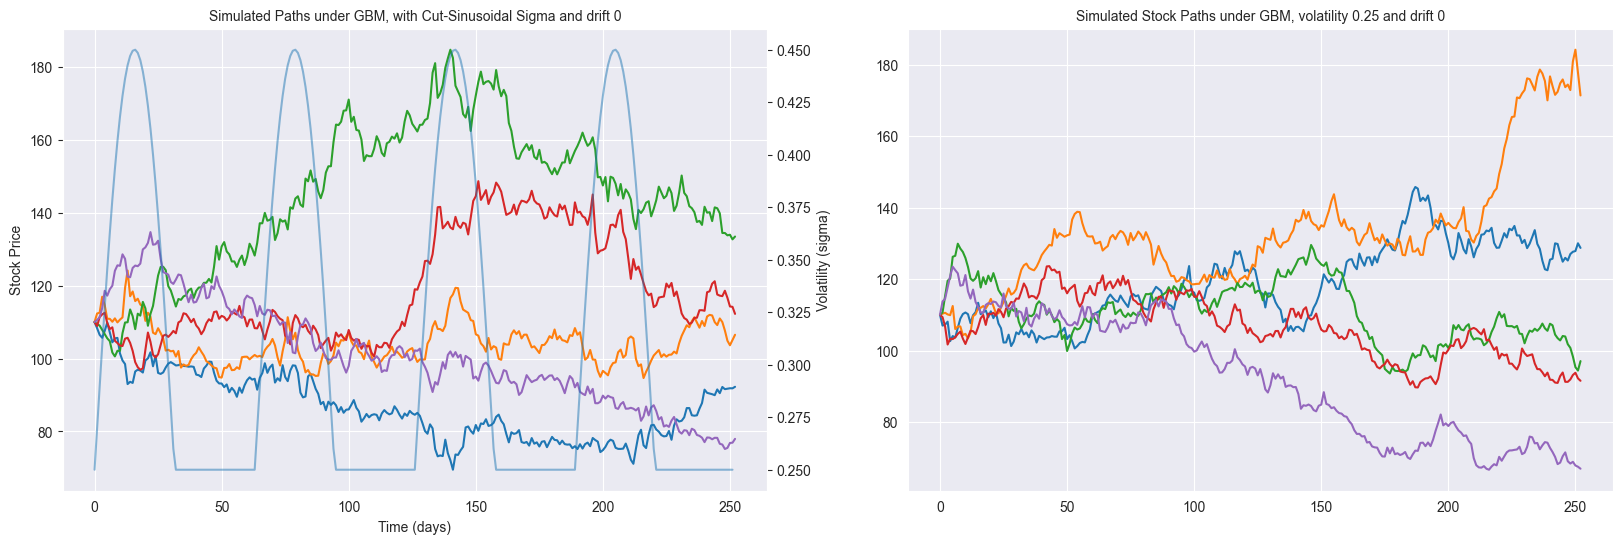

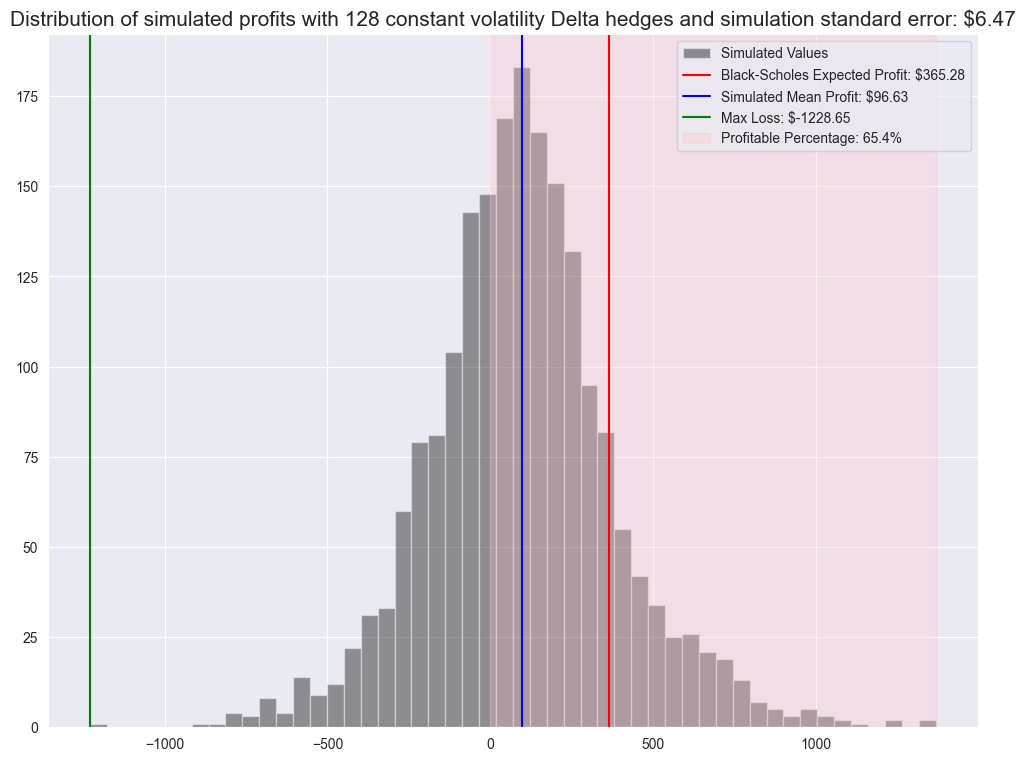

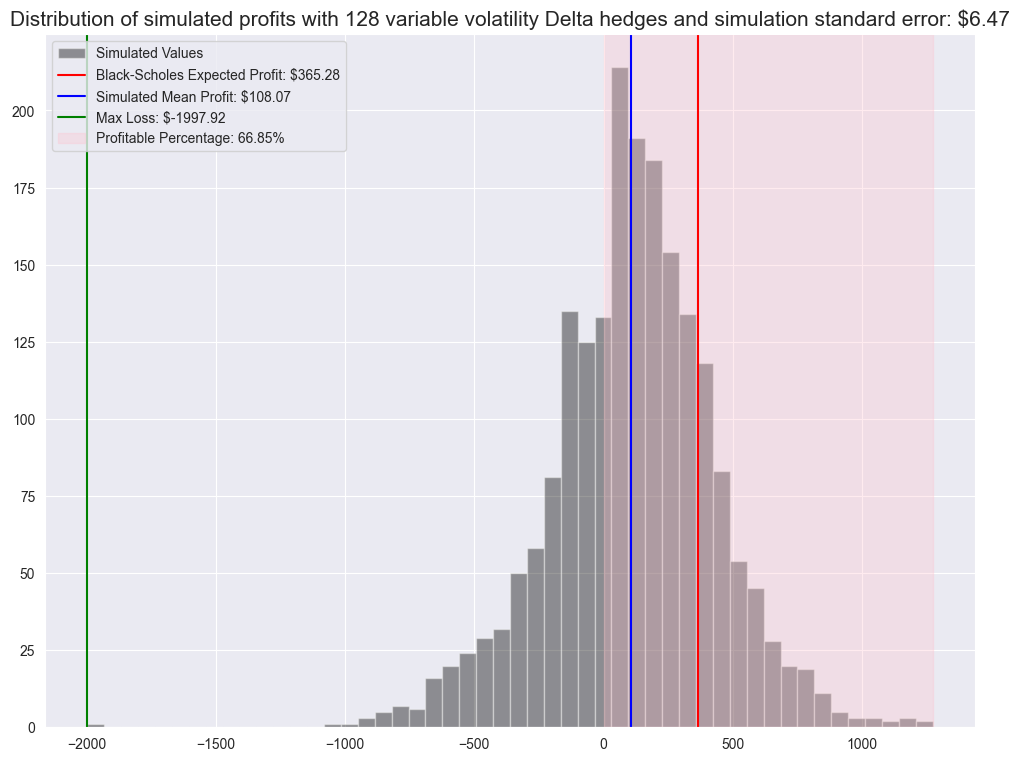

In [32]:
# Q: What happens when you sell options and delta hedge based on the Black-Sholes model and constant volatility,
# but the volatility is variable and follows the above cut-sinusoid relation?  
# We will focus on call options 

#Financial data
S0 = 110
K = 100
t = 1
r = 0.04
mu = 0
A = 0.2
base_sig = 0.25
n_sims = 2000
n_hedges = 128


#custom cut-sinusoid sigma (for visualization)
n_paths = 5
n_steps = 252
sigma = [ max(A*np.sin(4*2*np.pi*i / 252)+base_sig, base_sig) for i in range(n_steps)]

#simulate the stock paths
simulated_paths = stock_path_cut_sin_sigma(S0, t, r, mu, base_sig, A, n_paths, n_steps)

#plot stock paths 
#stock paths of GBM with cut_sin volatility
fig, ax = plt.subplots(1,2,figsize = (20,6))
ax[0].set_xlabel("Time (days)")
ax[0].set_ylabel("Stock Price")
for path in simulated_paths:
    ax[0].plot(path) 
ax[0].set_title(f'Simulated Paths under GBM, with Cut-Sinusoidal Sigma and drift {mu}', size = 10)

#plot cut-sinusoidal sigma
ax1 = ax[0].twinx()
ax1.set_ylabel("Volatility (sigma)")
ax1.grid(False)
ax1.plot(sigma, alpha=0.5)

#plot stock paths of GBM with constant volatility (denoting this as temporary since python does not have limited scopes)
noise_temp = np.random.normal(0,1,(n_paths, n_steps))
dt_temp = t/n_steps
increments_temp = (mu + r - .5*base_sig**2)*dt_temp + base_sig*np.sqrt(dt_temp)*noise_temp
log_returns_temp = np.cumsum(increments_temp, axis = 1)
paths_temp = S0*np.exp(log_returns_temp)
paths_temp = np.insert(paths_temp, 0, S0, axis = 1)
for path in paths_temp:
    ax[1].plot(path)    
ax[1].set_title(f'Simulated Stock Paths under GBM, volatility {base_sig} and drift {mu}', size = 10)
plt.show()



####
#simulate call selling with delta hedging profits 
#profit is num_options*(premium - sold_call_hedged)
premium = bs_call(S0,K,base_sig + .1,t,r)  #Increased volatility results in higher price in Black-Scholes model
#premium = bs_call(S0,K,base_sig + A,t,r)  #Increased volatility results in higher price in Black-Scholes model

num_options = 100
bs_price = bs_call(S0,K, base_sig,t,r)

#simulate profits from delta hedging the underlying stock movement(modeled by GBM with cut_sin volatility) 
#simulate two delta hedging volatilities: constant (base_sig) and variable (cut-sin) 
delta_sims = 250
sold_calls_hedged = cs_MC_stock_profits(S0, K, A, base_sig, t, r, mu, n_sims, n_hedges, delta_sims)
sold_calls_hedged_delta_var = cs_MC_stock_profits(S0, K, A, base_sig, t, r, mu, n_sims, n_hedges, delta_sims, True)

profits_hedged = num_options*(premium - sold_calls_hedged)
profits_hedged_delta_var = num_options*(premium - sold_calls_hedged_delta_var)

#Plot simulated returns
#constant volatility
plt.figure(figsize = (12,9))
plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
plt.axvspan(0,np.max(profits_hedged), color='pink', alpha=0.3,\
label = f'Profitable Percentage: {np.mean(profits_hedged>=0)*100}%')
plt.legend()
plt.title(f'Distribution of simulated profits with {n_hedges} constant volatility \
Delta hedges and simulation standard error: \${np.std(profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)
plt.show()

#variable vol
plt.figure(figsize = (12,9))
plt.hist(profits_hedged_delta_var, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
plt.axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
plt.axvline(np.mean(profits_hedged_delta_var), label = f'Simulated Mean Profit: ${np.mean(profits_hedged_delta_var):.2f}', color = 'blue')
plt.axvline(np.min(profits_hedged_delta_var), label = f'Max Loss: ${np.min(profits_hedged_delta_var):.2f}', color = 'green')
plt.axvspan(0,np.max(profits_hedged_delta_var), color='pink', alpha=0.3,\
label = f'Profitable Percentage: {np.mean(profits_hedged_delta_var>=0)*100}%')
plt.legend()
plt.title(f'Distribution of simulated profits with {n_hedges} variable volatility \
Delta hedges and simulation standard error: \${np.std(profits_hedged)/np.sqrt(n_sims):.2f}',size = 15)
plt.show()



